<a href="https://colab.research.google.com/github/thomouvic/txtanalytics/blob/main/doc_sim_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/shera
!cp /content/drive/MyDrive/shera/2022txt.zip .
!unzip -oq 2022txt.zip 

2013txt.zip  2017txt.zip  2021txt.zip			docvecs.csv
2014txt.zip  2018txt.zip  2022txt.zip
2015txt.zip  2019txt.zip  _digital_humanities_wiki.txt
2016txt.zip  2020txt.zip  docnames.csv


In [3]:
path = '2022txt'

In [4]:
from pathlib import Path

all_txt_files =[]
for file in Path(f"./{path}/").rglob("*.txt"):
  all_txt_files.append(file.parent / file.name)

n_files = len(all_txt_files)
print(n_files)

258


In [5]:
import pandas as pd

# Initialize an empty list to store the data
data = []

# Loop through the file names
for filename in all_txt_files:
    # Read the file into a string
    with open(filename, 'r') as f:
        text = f.read()
    
    # Append the string to the list
    data.append( (filename, text) )

# Create a dataframe from the list of strings
docdf = pd.DataFrame(data, columns=['filename', 'text'])
docdf

,filename,text
0,2022txt/244.txt,Investigating two Late Roman slag heaps in the...
1,2022txt/184.txt,6-7 October 2022 \nPhilipps-Universität Marbur...
2,2022txt/278.txt,QuoteKG :\nA Multilingual Knowledge Graph of Q...
3,2022txt/188.txt,"27 December 2022\n \nCarbé, E., Balbo, A., Tom..."
4,2022txt/169.txt,Thu Dau Mot University Journal of Science - Vo...
...,...,...
253,2022txt/207.txt,\ngiada cerri Shaking Heritage\nMuseum Collect...
254,2022txt/223.txt,\n \n \n Hidden Cities \nThis groundbreaking c...
255,2022txt/89.txt,\n 126 \n From A Student Perspective: Video T...
256,2022txt/345.txt,Hannes/uni00A0Werthner\nErich/uni00A0Prem\nEdw...


# TF/IDF

In [6]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

tfidf = TfidfVectorizer(stop_words=stopwords, min_df=2)
dt = tfidf.fit_transform(docdf["text"])
print('Number of bytes', dt.data.nbytes)
dt

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Number of bytes 6943792
CPU times: user 11.9 s, sys: 954 ms, total: 12.8 s
Wall time: 15.8 s


<258x111102 sparse matrix of type '<class 'numpy.float64'>'
	with 867974 stored elements in Compressed Sparse Row format>

# Finding the most similar documents

### Timing Cosine Similarity

In [7]:
%%time
from sklearn.metrics.pairwise import cosine_similarity
r = cosine_similarity(dt, dt, dense_output=False)

CPU times: user 276 ms, sys: 6.59 ms, total: 283 ms
Wall time: 322 ms


In [8]:
# A: Let's transform the sparse matrix to a pandas dataframe  
import pandas as pd

m = r.tocoo()
tuples = zip(m.row, m.col, m.data)
df = pd.DataFrame(tuples, columns =['docid1', 'docid2', 'score'])
df

# Filtering out duplicates
dup_pairs = df[ (0.99 < df['score']) & (df['docid1']<df['docid2']) ] 
# print( dup_pairs )
dup_list = dup_pairs['docid2'].tolist()
# print(dup_list)
df = df[~df['docid1'].isin(dup_list)]
df = df[~df['docid2'].isin(dup_list)]
# dup_pairs = df[ (0.99 < df['score']) & (df['docid1']<df['docid2']) ]
# print( dup_pairs )

# A: Let's keep only rows with similarity greater than a threshold. 
# A: We set the threshold so that each document has on average about 30 neighbors wrt similarity
# A: Also, let's remove rows with similarity close to 1. These are self-similarities. 
threshold = 0.18
df = df[ threshold <= df['score'] ]
df = df[ 0.99 > df['score'] ]
df.reset_index(drop=True, inplace=True)
df

,docid1,docid2,score
0,1,123,0.350531
1,1,158,0.185236
2,1,127,0.232183
3,1,238,0.187090
4,1,225,0.240378
...,...,...,...
2551,255,189,0.201343
2552,255,206,0.258844
2553,257,76,0.190273
2554,257,80,0.222428


In [9]:
print(df.groupby('docid1')['docid2'].count().sort_values(ascending=False).head(50))
print(docdf.iloc[194])

docid1
76     107
225    103
69      79
104     76
80      72
115     58
136     55
89      53
156     51
64      47
154     42
87      41
206     38
247     36
122     34
140     31
220     31
17      31
250     30
56      29
215     29
29      29
94      28
252     27
217     26
25      26
71      26
11      26
118     24
189     24
168     24
16      23
219     23
119     22
77      22
161     22
232     22
6       21
169     20
61      20
30      20
75      19
8       18
85      18
141     18
124     17
1       16
9       16
245     16
209     16
Name: docid2, dtype: int64
filename                                      2022txt/325.txt
text         \nAbstract—With the rapid rise of information...
Name: 194, dtype: object


In [10]:
# https://stackoverflow.com/questions/74175462/attributeerror-module-scipy-sparse-has-no-attribute-coo-array
!pip install 'scipy>=1.8'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [11]:
import networkx as nx
G = nx.Graph()
G = nx.from_pandas_edgelist(df, 'docid1', 'docid2')

# To visualize the graph use Gephi, or see: https://nightingaledvs.com/how-to-visualize-a-graph-with-a-million-nodes/ 

In [12]:
nx.write_gexf(G, "2022.gexf")

In [13]:
# Exploring some nodes from Gephi
print(docdf.iloc[232])

filename                                      2022txt/101.txt
text         \n \n \n \n \nEdinburgh Research Explorer  \n...
Name: 232, dtype: object


In [52]:
# Get modularity community partitioning from Gephi and 
# build a word map for the top 5 communities. 
# In Gephi go to Data Laboratory and save as csv.
# Now put it somewhere, e.g. /content/drive/MyDrive/shera/2022gephi.csv 
# and read it to a dataframe. 

comdf = pd.read_csv('/content/drive/MyDrive/shera/2022gephi.csv')

# Select the nodes of modularity class 0. This is the first class. 
# Repeat for modularity class 1, 2, 3, 4.
comlist = comdf[ comdf['modularity_class']==0 ]['id'].tolist()  
print(comlist)

# extract rows from docdf with ids in comlist
docdf_com = docdf.iloc[ comlist ]
docdf_com

[207, 162, 100, 139, 175, 85, 47, 51, 56, 255, 150, 36, 145, 149, 235, 108, 169, 135, 83, 96, 118, 114, 116]


,filename,text
207,2022txt/178.txt,\n \n \n Hidden Cities \nThis groundbreaking c...
162,2022txt/17.txt,123DHQ: Digital Humanities QuarterlyPreview202...
100,2022txt/243.txt,Державний вищий навчальний заклад \n«Ужгородсь...
139,2022txt/102.txt,"EUROVIS 2022/ T. Höllt, W. Aigner, and M. Agus..."
175,2022txt/356.txt,Acquisitions Programme \n2021–2024\n \nHarri...
85,2022txt/232.txt,This is an electronic reprint of the original ...
47,2022txt/254.txt,179 Poetry\ncreation story\nMaren Loveland\nHe...
51,2022txt/214.txt,1 \n \n \n \n \n \n \n \n \n \n \n \n \n \n...
56,2022txt/343.txt,Translation and\nSocial Media\nCommunication i...
255,2022txt/89.txt,\n 126 \n From A Student Perspective: Video T...


In [72]:
import regex as re
import nltk
from nltk.stem import PorterStemmer

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)


nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.update(['learners', 'also', 'https'])

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

def porter_stem(tokens):
  ps = PorterStemmer()
  return [ps.stem(t) for t in tokens]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

docdf_com['tokens'] = docdf_com['text'].apply(prepare, pipeline=pipeline)
# keeping only tokens with length >= 4
docdf_com['tokens'] = docdf_com['tokens'].apply(lambda li : [x for x in li if len(x)>=4])
docdf_com

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-72-53d6f659fd49>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docdf_com['tokens'] = docdf_com['text'].apply(prepare, pipeline=pipeline)
<ipython-input-72-53d6f659fd49>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docdf_com['tokens'] = docdf_com['tokens'].apply(lambda li : [x for x in li if len(x)>=4])


,filename,text,tokens
207,2022txt/178.txt,\n \n \n Hidden Cities \nThis groundbreaking c...,"[hidden, cities, groundbreaking, collection, e..."
162,2022txt/17.txt,123DHQ: Digital Humanities QuarterlyPreview202...,"[123dhq, digital, humanities, quarterlypreview..."
100,2022txt/243.txt,Державний вищий навчальний заклад \n«Ужгородсь...,"[державний, вищий, навчальний, заклад, ужгород..."
139,2022txt/102.txt,"EUROVIS 2022/ T. Höllt, W. Aigner, and M. Agus...","[eurovis, höllt, aigner, agus, short, paper, v..."
175,2022txt/356.txt,Acquisitions Programme \n2021–2024\n \nHarri...,"[acquisitions, programme, harri, ahonen, mika,..."
85,2022txt/232.txt,This is an electronic reprint of the original ...,"[electronic, reprint, original, article, repri..."
47,2022txt/254.txt,179 Poetry\ncreation story\nMaren Loveland\nHe...,"[poetry, creation, story, maren, loveland, mak..."
51,2022txt/214.txt,1 \n \n \n \n \n \n \n \n \n \n \n \n \n \n...,"[book, abstracts, table, contents, plenary, ta..."
56,2022txt/343.txt,Translation and\nSocial Media\nCommunication i...,"[translation, social, media, communication, pa..."
255,2022txt/89.txt,\n 126 \n From A Student Perspective: Video T...,"[student, perspective, video, tuto-, rials, le..."


In [73]:
# Counting tokens
from collections import Counter

counter = Counter()

# Call counter.update for each row of the column tokens. 
# Counter will be updated each time. 
_ = docdf_com['tokens'].map(counter.update) 
print(counter.most_common(20))

[('україни', 1622), ('language', 1337), ('research', 1163), ('data', 1073), ('corpus', 968), ('права', 944), ('право', 798), ('english', 756), ('social', 749), ('university', 676), ('public', 662), ('щодо', 647), ('digital', 632), ('wharton', 630), ('city', 623), ('history', 610), ('studies', 600), ('learner', 598), ('world', 589), ('information', 559)]


In [74]:
# transform counter into data frame
min_freq = 2
freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
freq_df = freq_df.query('freq >= @min_freq')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(20)

,freq
token,
україни,1622
language,1337
research,1163
data,1073
corpus,968
права,944
право,798
english,756
social,749


In [75]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

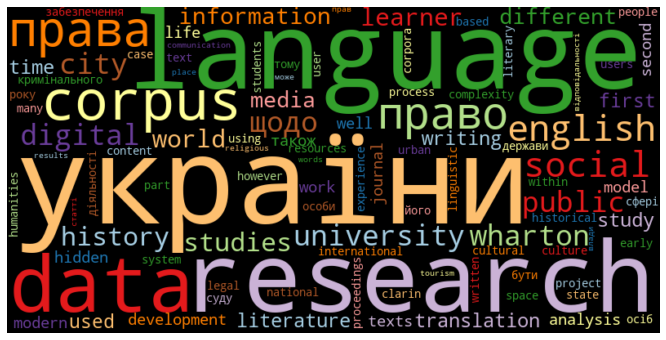

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
wordcloud(freq_df['freq'], max_words=100)    

<ipython-input-77-c92838ac73fd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


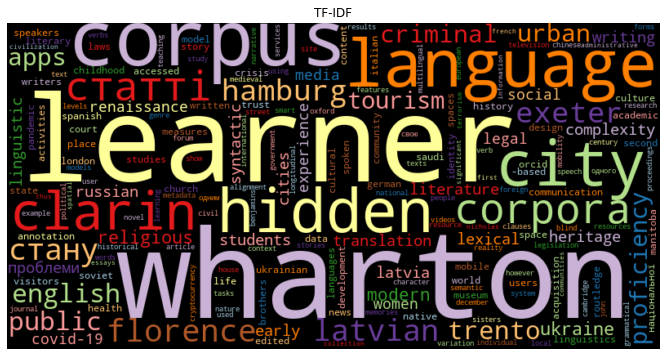

In [77]:
import numpy as np

def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

idf_df = compute_idf(docdf_com)
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
wordcloud(freq_df['tfidf'], title='TF-IDF', stopwords=['https', 'http'])

**Some conclusions about community 0.** 
These word maps could suggest a community of documents related to law, public policy, and digital tools. For example, document 100 (2022txt/243.txt) is about law practice in Ukraine and includes a considerable number of articles information law in Ukraine. 
Document 207 (2022txt/178.txt) is about public policy, museum placement, political conflict, and other societal matters.  
Finally, Robin Wharton is a medievalist, digital humanist, and attorney.   